## Imports

In [147]:
import pybinding as pb
import numpy as np
import matplotlib 
matplotlib.__version__ 
'3.1.0'
import matplotlib.pyplot as plt
from pybinding.repository import graphene

pb.pltutils.use_style()
%matplotlib inline

### Fundamental constants

In [2]:
h = 6.626069e-34    # Planck constant (Js)
h_ = h/(2*np.pi)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
Bfield = 0         # No magnetic field in this simulation

### Some geometries

In [3]:
"Equilateral triangle"
def triangle(side):
    return pb.Polygon([[-side/2, 0], [side/2, 0], [0, (side/2)*np.tan(np.pi/3)]])

"Rectangle"
def rectangle(width, height):
    x0 = width / 2
    y0 = height / 2
    return pb.Polygon([[x0, y0], [x0, -y0], [-x0, -y0], [-x0, y0]])
    
"Circle"
def circle(radius):
    def contains(x, y, z):
        return np.sqrt(x**2 + (2*y)**2) < radius
    return pb.FreeformShape(contains, width=[2*radius, 2*radius])

"Ring"
def ring(inner_radius, outer_radius):
    def contains(x, y, z):
        r = np.sqrt(x**2 + y**2)
        return np.logical_and(inner_radius < r, r < outer_radius)
    return pb.FreeformShape(contains, width=[2*outer_radius, 2*outer_radius])
    
"Stadium"
def stadium(length, radius):
    def contains(x, y, z):
        return np.logical_or( np.logical_or((x-length/2)**2+y**2<(radius)**2, (x+length/2)**2+y**2<(radius)**2 ) , np.logical_and( np.abs(y)<radius, np.abs(x)<length/2) )
    return pb.FreeformShape(contains, width=[length+2*radius, 2*radius])


## Defining some lattices

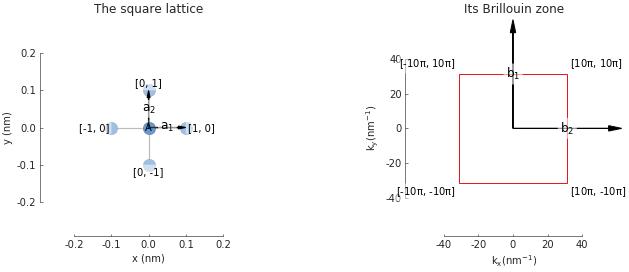

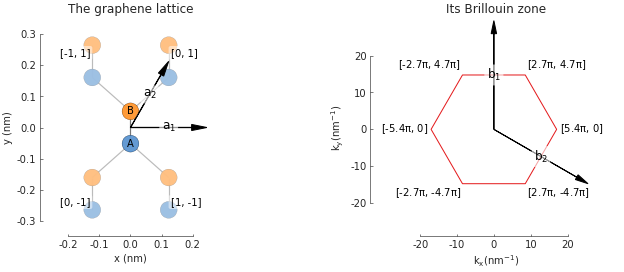

In [145]:
def square_lattice(d, t):
    # create a simple 2D lattice with vectors a1 and a2
    lat = pb.Lattice(a1=[d, 0], a2=[0, d])
    lat.add_sublattices(('A', [0, 0])) # add an atom called 'A' at position [0, 0]
    # (relative_index, from_sublattice, to_sublattice, energy)
    lat.add_hoppings(([0, 1], 'A', 'A', t),
                     ([1, 0], 'A', 'A', t))
    return lat

# we can quickly set a shorter unit length `d`
lattice = square_lattice(d=0.1, t=1)

plt.figure(figsize=(12,4))
plt.subplot(121, title="The square lattice")
lattice.plot()
plt.subplot(122, title="Its Brillouin zone")
lattice.plot_brillouin_zone()
plt.show()
plt.show()



def monolayer_graphene(a):
    """Return the lattice specification for monolayer graphene"""
#     a = 0.24595   # [nm] unit cell length
#     a_cc = 0.142  # [nm] carbon-carbon distance
    a_cc = a*(1-np.tan(np.pi/6)) # [nm] carbon-carbon distance
    t = -2.8      # [eV] nearest neighbour hopping

    # create a lattice with 2 primitive vectors
    lat = pb.Lattice(
        a1=[a, 0],
        a2=[a/2, a/2 * np.sqrt(3)]
    )

    lat.add_sublattices(
        # name and position
        ('A', [0, -a_cc/2]),
        ('B', [0,  a_cc/2])
    )

    lat.add_hoppings(
        # inside the main cell
        ([0,  0], 'A', 'B', t),
        # between neighboring cells
        ([1, -1], 'A', 'B', t),
        ([0, -1], 'A', 'B', t)
    )
    
    return lat


lattice = monolayer_graphene(0.24595)

plt.figure(figsize=(12,4))
plt.subplot(121, title="The graphene lattice")
lattice.plot()
plt.subplot(122, title="Its Brillouin zone")
lattice.plot_brillouin_zone()
plt.show()
plt.show()

In the figure we see lattice vectors $a_1$ and $a_2$ which were used to initialize [`Lattice`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice). These vectors describe a Bravais lattice with an infinite set of positions,

$$
\vec{R} = n_1 \vec{a}_1 + n_2 \vec{a}_2,
$$

where $n_1$ and $n_2$ are integers. The blue circle labeled A represents the atom which was created with the [`Lattice.add_sublattices()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.add_sublattices) method. The slightly faded out circles represent translations of the lattice in the primitive vector directions, i.e. using the integer index $[n_1, n_2]$.

The hoppings are specified using the [`Lattice.add_hoppings()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.add_hoppings) method and each one consists of `(relative_index, from_sublattice, to_sublattice, energy)`:

* The main cell always has the index $[n_1, n_2]$ = [0, 0]. The `relative_index` represents the number of integer steps needed to reach another cell starting from the main one. Each cell is labeled with its `relative_index`, as seen in the figure.
  
* A hopping is created between the main cell and a neighboring cell specified by `relative_index`. Two hoppings are added in the definition: [0, 1] and [1, 0]. The opposite hoppings [0, -1] and [-1, 0] are added automatically to maintain hermiticity.
  
* This lattice consists of only one sublattice so the `from` and `to` sublattice fields are trivial. Generally, `from_sublattice` indicates the sublattice in the [0, 0] cell and `to_sublattice` in the neighboring cell. This will be explained further in the next example.
  
* The last parameter is simply the value of the hopping energy.

## Parameters of the experiment

### Scaling

In [105]:
asquare = 0.1 # [nm] a is the lattice parameter
tsquare = 1.0 # [eV] t is the hopping parameter
scaling = 1 # scaling factor
"""scaling"""
a = asquare * scaling
t = tsquare / scaling**2

### Fermi energy, velocity and wavelength

In [135]:
"Fermi energy"
Ef = 0.3106*t   # Chosen Fermi energy [eV]
m = h_**2/(2*a**2*t)*10**18 # Effective mass
k_F = np.sqrt(2*m*Ef/(h_**2)) # Wavevector
v_F = np.sqrt(2*Ef/m) # Fermi velocity

print("E_F = ", Ef, "eV")
print("vF = ", v_F)
print("m* = ", m)

E_F =  0.3106 eV
vF =  1.0569504686622894e+24
m* =  5.560606662704104e-49


## Verifying of the conditions

In [136]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F = 2 * np.pi * a * np.sqrt(t / Ef) # computation of the wavelength
print("\lambda_F = ", lambda_F, "[nm]")
if lambda_F/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')
    
""" The Fermi energy must be smaller than the hopping parameter t"""
print("E_F = ", Ef)
if Ef/t > 0.5:
    print('Warning : E_F must be smaller than the hopping parameter t')

\lambda_F =  1.1274028871440223 [nm]
E_F =  0.3106


## Adding a smooth potential

In [137]:
def smooth_pot(effrad, radius, length, H):
    @pb.onsite_energy_modifier
    def potential(x, y):
        pot = np.zeros( len(x) )
        for i in np.arange( len(x) ) :
            if ( abs(y[i]) < radius and abs(x[i]) < length/2 ):
                pot[i] = H* (y[i]**2 -effrad**2) / (radius**2-effrad**2)
            elif ( x[i] > 0 ):
                pot[i] = H* ( (x[i]-length/2)**2+y[i]**2 -effrad**2 ) / (radius**2-effrad**2)
            elif ( x[i] < 0 ): 
                pot[i] = H* ( (x[i]+length/2)**2+y[i]**2 -effrad**2 ) / (radius**2-effrad**2)
            
            if ( (x[i]-length/2)**2+y[i]**2<effrad**2 or (x[i]+length/2)**2+y[i]**2<(effrad)**2 or ( np.abs(y[i])<effrad and np.abs(x[i])<length/2) ):
                pot[i] = 0
        return pot
    return potential

## Building the geometry

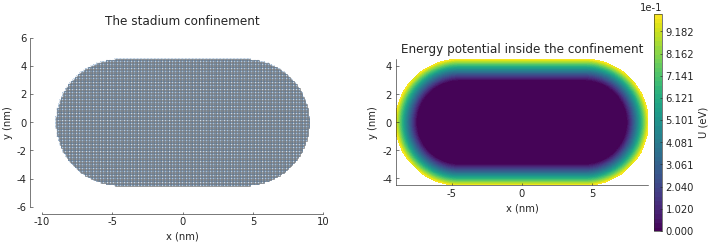

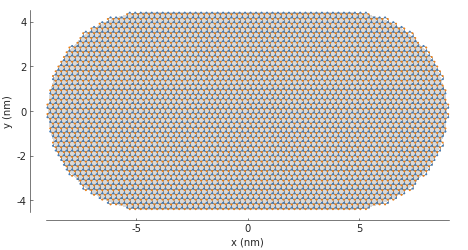

In [156]:
# Parameters 
radius = 4*lambda_F        # in [nm]
length = 2*radius # distance between the two semicircles
coeff = 0.66
effrad = coeff*radius
H = 1             # Potential height on the contour (in [eV])

# Building the model
model = pb.Model(
    square_lattice(a, t),
    stadium(length, radius),
    smooth_pot(effrad, radius, length, H)
)

plt.figure( figsize = (12,4) )
plt.subplot(1,2,1, title='The stadium confinement' )
model.plot()
plt.subplot(1,2,2, title='Energy potential inside the confinement' )
model.onsite_map.plot_contourf()
pb.pltutils.colorbar(label="U (eV)")
plt.show

plt.figure( figsize = (12,4) )
model2 = pb.Model(
    graphene.monolayer(),
    stadium(length, radius)
)
model2.plot()
model2.shape.plot()
plt.show()

## Computing electronic properties in the system

### Visualizing the pdf 
$P(\mathbf{r}) = |\Psi_n (\mathbf{r})|^2 $ 

input of **solver.calc_probability()** n : int or array_like 
            Index of the desired eigenstate. If an array of indices is given, the
            probability will be calculated at each one and a sum will be returned.

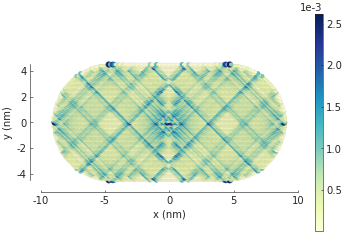

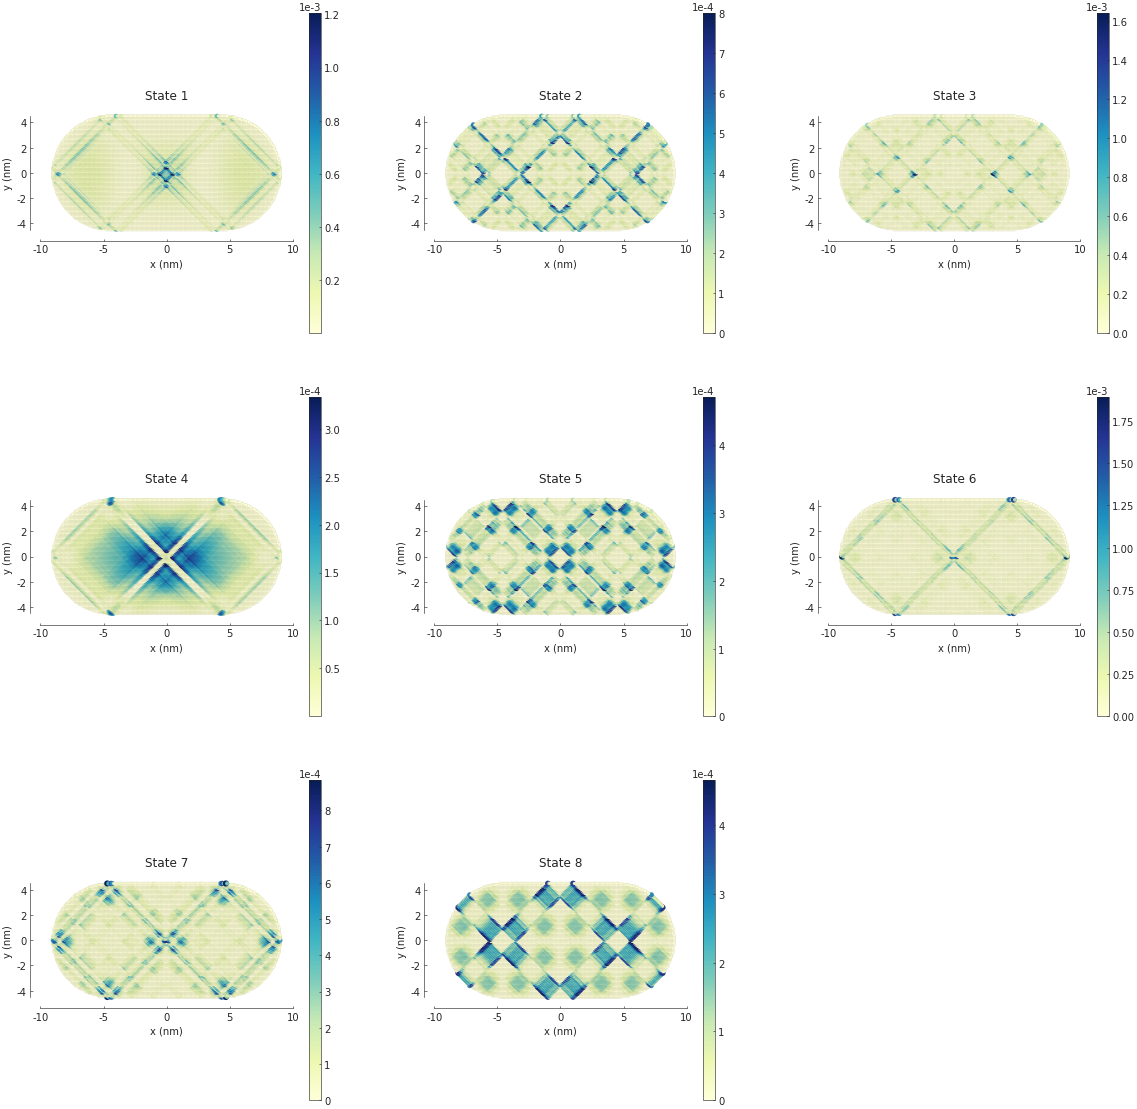

In [154]:
nmodes = 8

probability_map = solver.calc_probability( np.arange(nmodes) )
probability_map.plot(site_radius=(0.12, 0.24))
pb.pltutils.colorbar()
plt.show()

plt.figure(figsize= (20,20) )
for i in np.arange(nmodes):
    plt.subplot(np.ceil(nmodes/3),3,i+1, title='State '+str(i+1) )
    probability_map = solver.calc_probability(i)
    probability_map.plot(site_radius=(0.12, 0.24))
    pb.pltutils.colorbar()
plt.show()

### Visualizing the Local Density Of States
$LDOS (\mathbf{r}) = \frac{1}{\sqrt{2 \pi} \sigma} \sum_{n=1}^N |\Psi_n (\mathbf{r})|^2 \exp \left( - \frac{1}{2} \left( \frac{E_n-E}{\sigma} \right)^2 \right)$

### For different eigenstates $N \rightarrow \sum_{n=1}^N E_n$

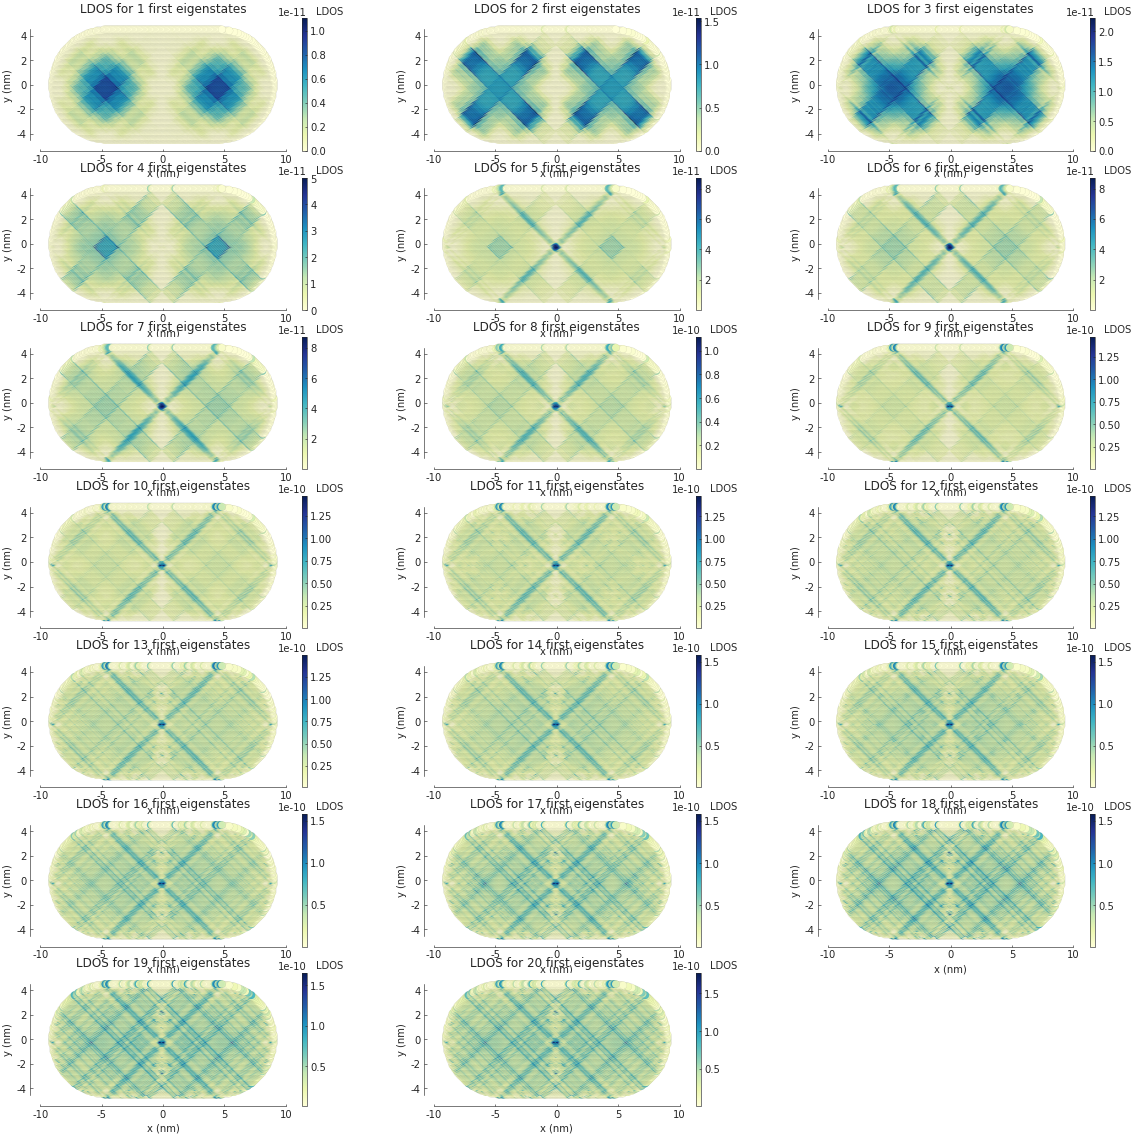

In [155]:
N = 20 # Number of eigenmodes taken into account

plt.figure( figsize = (20,20) )
for i in np.arange(N) :
    solver = pb.solver.arpack(model, k=i+1)  # only the i lowest eigenstates  
    ldos = solver.calc_spatial_ldos(energy=Ef, broadening=0.05)  # broadening = sigma, Ef in [eV]
    
    plt.subplot(np.ceil(N/3),3,i+1, title='LDOS for '+str(i+1)+ ' first eigenstates' )
    ldos.plot(site_radius=(0.06, 0.24)) #(0.03, 0.12)
    pb.pltutils.colorbar(label="                "+"LDOS")
plt.show()

### For different energy levels $E$

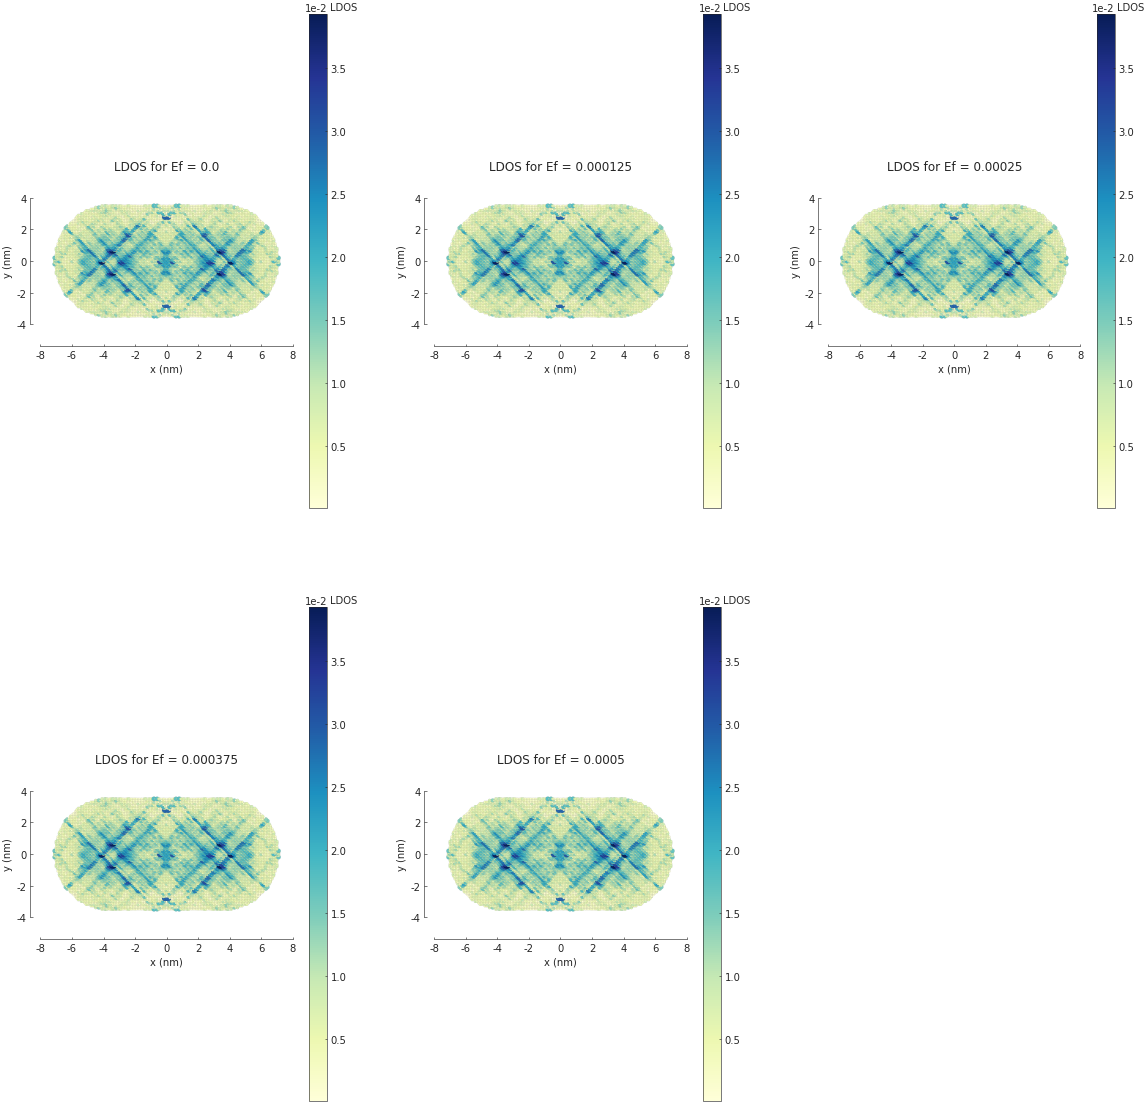

In [114]:
numplots = 5
energies = np.linspace(0.0, 0.0005, numplots)
neigen = 10
solver = pb.solver.arpack(model, k=neigen)  # only the neigen lowest eigenstates 
plt.figure( figsize = (20,20) )
for i in np.arange(numplots):
    Ef = energies[i]   
    ldos = solver.calc_spatial_ldos(energy=Ef, broadening=0.05)  # eV
    plt.subplot(np.ceil(numplots/3),3,i+1, title='LDOS for Ef = '+str(Ef) )
    ldos.plot(site_radius=(0.06, 0.24)) #(0.03, 0.12)
    pb.pltutils.colorbar(label="                "+"LDOS")
plt.show()

### Computing the eigenvalues $E_n$

[0.1 0.4]


(-0.0002, 0.0002)

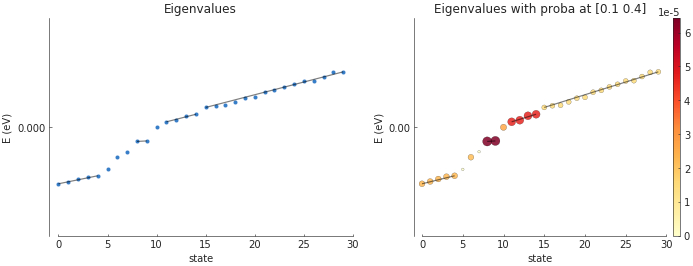

In [93]:
plt.figure( figsize=(12,4) )

n_eigen = 30
solver = pb.solver.arpack(model, k=n_eigen)

plt.subplot(1,2,1, title='Eigenvalues' )
eigenvalues = solver.calc_eigenvalues()
eigenvalues.plot()
axes = plt.gca()
axes.set_ylim([-0.0002,0.0002])

pos = np.array([0.1, 0.4])
print(pos)
plt.subplot(1,2,2, title='Eigenvalues with proba at '+str(pos) )
eigenvalues = solver.calc_eigenvalues(map_probability_at=[pos[0], pos[1]])  # position in [nm]
eigenvalues.plot_heatmap(show_indices=False)
pb.pltutils.colorbar()
axes = plt.gca()
axes.set_ylim([-0.0002,0.0002])

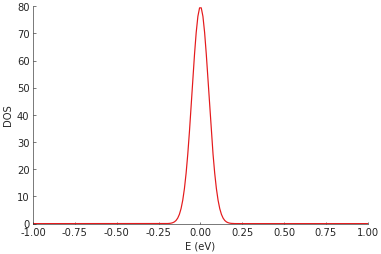

In [129]:
dos = solver.calc_dos(energies=np.linspace(-1, 1, 200), broadening=0.05)  # [eV]
dos.plot()